# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

from datetime import date, timedelta
from tqdm import tqdm
import time
import datetime
%matplotlib inline
sns.set_style('dark')

In [2]:
train_pre = pd.read_csv('Data/初赛/train.csv')
test_pre = pd.read_csv('Data/初赛/test.csv')
answer_pre = pd.read_csv('Data/初赛/answer.csv')
answer_pre.columns = ['timestamp', 'temp_in']
train_pre.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in']
test_pre.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in']
test_pre = pd.merge(test_pre, answer_pre, on='timestamp', how='left')
test_pre.temp_in.fillna(31.5, inplace=True)
train_pre['time'] = pd.to_datetime(train_pre[['year', 'month', 'day', 'hour', 'minute']])
test_pre['time'] = pd.to_datetime(test_pre[['year', 'month', 'day', 'hour', 'minute']])
data_pre = pd.concat([train_pre, test_pre])

train_final = pd.read_csv('Data/复赛/train.csv')
test_final = pd.read_csv('Data/复赛/test.csv')
sample_final = pd.read_csv('Data/复赛/提交样例.csv')
train_final.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in']
test_final.columns = ['timestamp', 'year', 'month', 'day', 'hour', 'minute', 'second', 'temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in']
sample_final.columns = ['timestamp', 'temp_in']
train_final['time'] = pd.to_datetime(train_final[['year', 'month', 'day', 'hour', 'minute']])
test_final = pd.merge(sample_final[['timestamp']], test_final, on='timestamp', how='left')
# test_final['time'] = pd.to_datetime(test_final[['year', 'month', 'day', 'hour', 'minute']])
test_final['time'] = [datetime.datetime.fromtimestamp(x) for x in test_final['timestamp']]
test_final['year'] = test_final.time.dt.year
test_final['month'] = test_final.time.dt.month
test_final['day'] = test_final.time.dt.day
test_final['hour'] = test_final.time.dt.hour
test_final['minute'] = test_final.time.dt.minute
test_final['second'] = test_final.time.dt.second


Preliminary:

- train: 2019-3-14 01:00 ~ 2019-4-3 00:59 per min
- test: 2019-4-3 01:00 ~ 2019-4-13 00:57 per 30mins

Final:
- train: 2020-01-13 00:00 ~ 2020-01-22 23:59 per min
- test: 2020-02-01 00:10 ~ 2020-02-05 22:10 per 2hoursto_datetime

## 填充每一分钟

In [3]:
time = {'year': [], 'month': [], 'day': [], 'hour': [], 'minute': []}
for day in range(14, 32):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2019)
            time['month'].append(3)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

for day in range(1, 3):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2019)
            time['month'].append(4)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

full_time = pd.DataFrame(time)
full_time['time'] = pd.to_datetime(full_time[['year', 'month', 'day', 'hour', 'minute']])
train_pre_full = full_time.loc[(full_time.time >= '2019-3-14 01') & (full_time.time < '2019-4-3 01'), :]

train_pre = pd.merge(train_pre_full, train_pre, on=['year', 'month', 'day', 'hour', 'minute', 'time'], how='left')
train_pre.drop(['second'], axis=1, inplace=True)
train_pre.drop_duplicates(['month', 'day', 'hour', 'minute'], inplace=True)
train_pre.reset_index(inplace=True, drop=True)

In [4]:
time = {'year': [], 'month': [], 'day': [], 'hour': [], 'minute': []}
for day in range(21, 23):
    for hour in range(0, 24):
        for minute in range(0, 60):
            time['year'].append(2020)
            time['month'].append(1)
            time['day'].append(day)
            time['hour'].append(hour)
            time['minute'].append(minute)

full_time = pd.DataFrame(time)
full_time['time'] = pd.to_datetime(full_time[['year', 'month', 'day', 'hour', 'minute']])

# train_final = pd.merge(full_time, train_final, on=['year', 'month', 'day', 'hour', 'minute', 'time'], how='left')
train_final = pd.merge(full_time, train_final, on=['year', 'month', 'day', 'hour', 'minute', 'time'], how='outer')
train_final.drop(['second'], axis=1, inplace=True)
train_final.drop_duplicates(['month', 'day', 'hour', 'minute'], inplace=True)
train_final.reset_index(inplace=True, drop=True)

## 异常值处理

In [5]:
train_pre.fillna(method='ffill', inplace=True)
train_final.fillna(method='ffill', inplace=True)

In [6]:
for feat in ['hum_out', 'hum_in', 'air_out', 'air_in']:
    for df in [train_pre, train_final]:
        lower, upper = np.percentile(df[feat], (3, 97))
        df.loc[(df[feat] < lower) | (df[feat] > upper), feat] = np.NaN

In [7]:
train_pre.fillna(method='ffill', inplace=True)
train_final.fillna(method='ffill', inplace=True)
test_final.loc[test_final['air_out']==927.1, 'air_out'] = 978.7

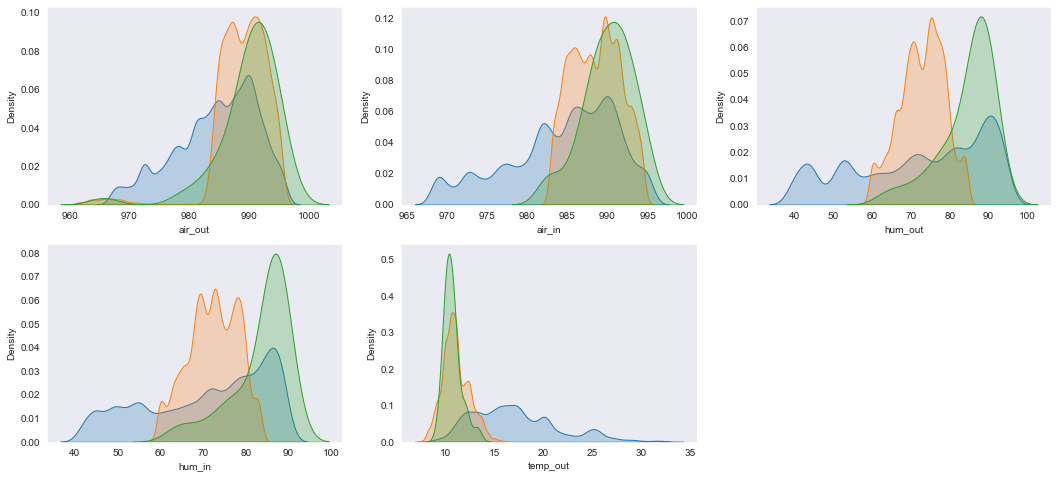

In [8]:
cols = ['air_out', 'air_in', 'hum_out', 'hum_in', 'temp_out']
plt.figure(figsize=(18,8))
for i in range(5):
    plt.subplot(2,3,i+1)
    sns.kdeplot(train_pre[cols[i]], shade=True, label='2019 train '+cols[i])
    sns.kdeplot(train_final[cols[i]], shade=True, label='2020 train '+cols[i])
    sns.kdeplot(test_final[cols[i]], shade=True, label='2020 test '+cols[i])

## 手动填充 Test

In [9]:
for d in [1,2,3,5]:
    for h in range(0, 24, 2):
        h_2 = h+2 if h != 22 else 0
        d_1 = 22 if h != 22 else 21
        d_2 = d if h != 22 else d+1
        if d == 3 and h == 22:
            d_2 = 5
        train_series = train_final[(train_final.time >= '2020-01-{} {}:10'.format(d_1, h)) & (train_final.time < '2020-01-22 {}:10'.format(h_2))][cols]
        test_series = test_final[test_final.time == '2020-02-{} {}:10:30'.format(d, h)][cols]
        residual = train_series[:1].values - test_series.head(1).values
        try:
            test_final.loc[(test_final.time > '2020-02-{} {}:10:30'.format(d, h)) & (test_final.time < '2020-02-{} {}:10:30'.format(d_2, h_2)), cols] = (train_series[1:] - residual).values
        except:
            test_final.loc[(test_final.time > '2020-02-{} {}:10:30'.format(d, h)) & (test_final.time < '2020-02-{} {}:10:30'.format(d_2, h_2)), cols] = (train_series[1:] - residual).values[:109]

## 特征工程

In [10]:
day = 24*60*60
hour = 60*60
minute = 60
for df in [train_final, test_final]:
    df['day sin'] = np.sin(df['timestamp'] * (2 * np.pi / day))
    df['day cos'] = np.cos(df['timestamp'] * (2 * np.pi / day))
    df['hour sin'] = np.sin(df['timestamp'] * (2 * np.pi / hour))
    df['hour cos'] = np.cos(df['timestamp'] * (2 * np.pi / hour))
    df['minute sin'] = np.sin(df['timestamp'] * (2 * np.pi / minute))
    df['minute cos'] = np.cos(df['timestamp'] * (2 * np.pi / minute))

In [11]:
matrix = pd.concat([train_final, test_final])

In [ ]:
# 基本聚合特征
features = ['temp_out', 'air_out', 'air_in']
group_feats = []
for f in tqdm(features):
    matrix['MDH_{}_medi'.format(f)] = matrix.groupby(['month','day','hour'])[f].transform('median')
    matrix['MDH_{}_mean'.format(f)] = matrix.groupby(['month','day','hour'])[f].transform('mean')
    matrix['MDH_{}_max'.format(f)] = matrix.groupby(['month','day','hour'])[f].transform('max')
    matrix['MDH_{}_min'.format(f)] = matrix.groupby(['month','day','hour'])[f].transform('min')
    matrix['MDH_{}_std'.format(f)] = matrix.groupby(['month','day','hour'])[f].transform('std')
#     matrix['DH_{}_medi'.format(f)] = matrix.groupby(['day','hour'])[f].transform('median')
#     matrix['DH_{}_mean'.format(f)] = matrix.groupby(['day','hour'])[f].transform('mean')
#     matrix['DH_{}_max'.format(f)] = matrix.groupby(['day','hour'])[f].transform('max')
#     matrix['DH_{}_min'.format(f)] = matrix.groupby(['day','hour'])[f].transform('min')
#     matrix['DH_{}_std'.format(f)] = matrix.groupby(['day','hour'])[f].transform('std')

    group_feats.append('MDH_{}_medi'.format(f))
    group_feats.append('MDH_{}_mean'.format(f))
#     group_feats.append('DH_{}_medi'.format(f))
#     group_feats.append('DH_{}_mean'.format(f))

In [ ]:
# 基本交叉特征
for f1 in tqdm(features + group_feats):
    for f2 in features + group_feats:
        if f1 != f2:
            colname = '{}_{}_ratio'.format(f1, f2)
            matrix[colname] = matrix[f1].values / matrix[f2].values

matrix = matrix.fillna(method='bfill')

In [12]:
cols = ['temp_out', 'air_out', 'air_in']

# 历史信息提取
matrix['dt'] = matrix['day'].values + (matrix['month'].values - 1) * 31

features = cols + ['temp_in']
for f in features:
    tmp_df = pd.DataFrame()
    for t in tqdm(range(13, 23)):
        tmp = matrix[matrix['dt'] < t].groupby(['hour'])[f].agg({'mean'}).reset_index()
        tmp.columns = ['hour', 'hit_{}_mean'.format(f)]
        tmp['dt'] = t
        tmp_df = tmp_df.append(tmp)

    matrix = matrix.merge(tmp_df, on=['dt', 'hour'], how='left')

matrix = matrix.fillna(method='ffill')

100%|██████████| 10/10 [00:00<00:00, 114.30it/s]


In [13]:
# lag features
# features = ['temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in']
features = ['temp_out', 'air_out', 'air_in']
lags = [1, 2, 3, 4]

for l in tqdm(lags):
    tmp = matrix[features+['time']].copy()
    tmp.time += pd.Timedelta(str(l) + ' hour')
    col_names = ['lag_'+str(l)+'_'+f for f in features]
    tmp.columns = col_names + ['time']
    matrix = pd.merge(matrix, tmp, on='time', how='left')
    del tmp

matrix.fillna(method='ffill', inplace=True)

100%|██████████| 4/4 [00:00<00:00, 23.79it/s]


In [14]:
# Trend
for feat in features:
    for n in lags:
        matrix['trend_'+str(n)+'_'+feat] = matrix[feat] - matrix['lag_'+str(n)+'_'+feat]

matrix.fillna(method='ffill', inplace=True)

In [15]:
lags = [1,3,6]
matrix.set_index('time', inplace=True)
matrix.sort_index(inplace=True)

for feat in tqdm(features):
    for l in lags:
        lag_hour = str(l) + 'h'
        matrix['mean_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).mean()
        matrix['median_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).median()
        matrix['max_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).max()
        matrix['min_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).min()
        matrix['std_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).std()
        matrix['skew_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).skew()
        matrix['q1_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).quantile(quantile=0.25)
        matrix['q3_'+str(l)+'_hours_'+feat] = matrix[feat].rolling(lag_hour).median(quantile=0.75)
        matrix['var_'+str(l)+'_hours_'+feat] = matrix['std_'+str(l)+'_hours_'+feat] / matrix['mean_'+str(l)+'_hours_'+feat]
        
matrix.reset_index(inplace=True)

100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


## Split the data

In [ ]:
features = ['temp_out', 'hum_out', 'air_out', 'hum_in', 'air_in', 'temp_in', 'day sin', 'day cos', 'hour sin', 'hour cos', 'minute sin', 'minute cos']
column_indices = {name: i for i, name in enumerate(features)}

n = len(train_final)
train_df = train_final[0:int(n*0.7)].copy()[features]
val_df = train_final[int(n*0.7):int(n*0.9)].copy()[features]
test_df = train_final[int(n*0.9):].copy()[features]

num_features = len(features)

## Normalize the data

In [ ]:
train_mean = train_df[cols].mean()
train_std = train_df[cols].std()

train_df.loc[:, cols] = (train_df[cols] - train_mean) / train_std
val_df.loc[:, cols] = (val_df[cols] - train_mean) / train_std
test_df.loc[:, cols] = (test_df[cols] - train_mean) / train_std

In [ ]:
df_std = (train_final[cols] - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_final[cols].keys())

## Data Window

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    def plot(self, model=None, plot_col='temp_out', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], 
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
        
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [ ]:
OUT_STEPS = 119
multi_window = WindowGenerator(input_width=1,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS, 
                               train_df=train_df[cols], 
                               val_df=val_df[cols], 
                               test_df=test_df[cols])

multi_window.plot()
multi_window

## AutoRegressive Model

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=patience, 
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps # 119
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(5)
        
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window)

multi_val_performance = {}
multi_performance = {}
multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

# Modeling

In [16]:
data = matrix.copy()

In [17]:
features_to_drop = ['timestamp', 'year', 'second', 'time', 'temp_in', 'hum_out', 'hum_in']

num = int(len(train_final)*0.8)
X_train = data.iloc[:num].drop(features_to_drop, axis=1)
y_train = data.iloc[:num]['temp_in'] - data.iloc[:num]['temp_out']
X_val = data.iloc[num:len(train_final)].drop(features_to_drop, axis=1)
y_val = data.iloc[num:len(train_final)]['temp_in'] - data.iloc[num:len(train_final)]['temp_out']
X_test = data.loc[data.time >= '2020-02-01'].drop(features_to_drop, axis=1)

## XGBoost

In [18]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

In [19]:
%%time

model = XGBRegressor(max_depth=8,
                     n_estimators=50000,
                     min_child_weight=5, 
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     eta=0.001,
                     seed=2020)
model.fit(X_train, 
          y_train, 
          eval_metric='rmse', 
          eval_set=[(X_train, y_train), (X_val, y_val)], 
          verbose=500, 
          early_stopping_rounds=1000)

[0]	validation_0-rmse:0.49107	validation_1-rmse:0.48765
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 1000 rounds.
[500]	validation_0-rmse:0.31472	validation_1-rmse:0.32231
[1000]	validation_0-rmse:0.20780	validation_1-rmse:0.25382
[1500]	validation_0-rmse:0.14364	validation_1-rmse:0.23719
[2000]	validation_0-rmse:0.10578	validation_1-rmse:0.23908
[2500]	validation_0-rmse:0.08355	validation_1-rmse:0.24511
Stopping. Best iteration:
[1624]	validation_0-rmse:0.13231	validation_1-rmse:0.23667

CPU times: user 6min 43s, sys: 3.14 s, total: 6min 46s
Wall time: 2min


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, eta=0.001, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.00100000005, max_delta_step=0, max_depth=8,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=50000, n_jobs=0, num_parallel_tree=1,
             random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=2020, subsample=0.5, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [21]:
pred_test_xgb = model.predict(X_test, ntree_limit=model.best_ntree_limit)
submission = pd.DataFrame({'time': test_final.timestamp, 
                           'temperature': test_final.temp_out + pred_test_xgb})
submission.to_csv('submissions/final/xgb_submission.csv', index=False)

In [ ]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (20,35))